SAC Paper : [Soft Actor Critic v2.](https://arxiv.org/abs/1801.01290)

In [1]:
import math
import random

# import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt


use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

## Defining Ingredient of RL

In [2]:
# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done, t):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done, t)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, t = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done, t
    
    def __len__(self):
        return len(self.buffer)

class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done , t):
#         assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done, t))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done, t)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        t           = batch[5]
        return states, actions, rewards, next_states, dones, indices, weights, t
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

# Plot (losses = [mean_loss, std_loss, z_loss, v_loss, q_1_loss, q_2_loss, policy_loss_with_reg])
def plot(iteration, losses, rewards):
    clear_output(True)
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('iter %s. reward: %s' % (iteration, rewards[-1]))
    plt.plot(rewards)
    
    plt.subplot(122)
    plt.title('iter %s. Policy loss with reg: %s' % (iteration, losses['policy_loss_with_reg'][-1]))
    plt.plot(losses['policy_loss_with_reg'])
    
    plt.show()
#     plt.figure(figsize=(20,5))
#     plt.subplot(131)
#     plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
#     plt.plot(rewards)
#     plt.show()
    
#     fig = plt.figure(figsize=(15,30))
    fig = plt.figure(figsize=(20, 5))
    # plt.rcParams['figure.figsize'] = [15, 30]
    i = 1
    
    losses_copy = losses.copy()
    losses_copy.pop('policy_loss_with_reg')
    for key, value in losses_copy.items():
        ax = fig.add_subplot(2, 3, i)
        ax.set_title(key, fontdict={'family':'serif', 'color':'darkred' })
        ax.set_xlabel('iteration', fontdict={'size':7})
        ax.set_ylabel('loss', fontdict={'size':7})
        ax.plot(value)
        fig.subplots_adjust(hspace = 1)
        i += 1
    plt.show()

# test_env
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        action = policy_net.get_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

# Value Network (Critic)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim + 1, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, t):
        x = torch.cat([state,t],1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Soft Q Network (Critic)
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions + 1, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action, t):
        x = torch.cat([state, action, t], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

    
# PolicyNetwork (Actor)
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=1.8): #log_std_max=2
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size) # nn.Linear(hidden_size, num_actions)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
#        policy = F.softmax(x)
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std # policy
    
    def evaluate(self, state, epsilon=1e-6):
        
        mean, log_std = self.forward(state) # 여기선 state가 (100,)으로 들어감
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z = normal.rsample() # bounding 안 하고 그대로 사용
        
        action = torch.empty_like(z)
        logjacobian = torch.empty_like(z)
        for n in range(batch_size):
            action[n] = F.hardtanh(z[n], min_val = 0.1, max_val = float(state[n]))
            
            if  0.1 < z[n] < float(state[n]):
                logjacobian[n] = torch.log(torch.Tensor([1])) # 0
            else:
                logjacobian[n] = torch.log(torch.Tensor([0.0001])) # log 0은 무한대라 어느 정도의 penalty를 주는 걸로 고려
       
        log_prob = normal.log_prob(z) - logjacobian
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z , mean, log_std 
        
    
    def get_action(self, state):
        state = torch.Tensor(state).unsqueeze(0).to(device)
#        policy = self.forward(state)
#        _, action = torch.max(policy)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        
        z = normal.sample()
        action = F.hardtanh(z, min_val = 0.1, max_val = float(state)) 
#        z      = normal.sample()
#        action = torch.tanh(z)
        
        action  = action.detach().cpu().numpy()
        return action[0] # action

In [3]:
def soft_q_update(batch_size, 
           beta,
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=1e-3,
           soft_tau= 5e-3 #1e-2,
          ):
    # sample from replay buffer
#     state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights, t = replay_buffer.sample(batch_size, beta) 

    state      = torch.Tensor(state).unsqueeze(1).to(device)
    next_state = torch.Tensor(next_state).unsqueeze(1).to(device)
    action     = torch.Tensor(action).unsqueeze(1).to(device)
    reward     = torch.Tensor(reward).unsqueeze(1).to(device)
    done       = torch.Tensor(np.float32(done)).unsqueeze(1).to(device)
    weights    = torch.Tensor(weights).unsqueeze(1).to(device)
    t          = torch.Tensor(t).unsqueeze(1).to(device)
    
    
    # calculate loss for v
    # Jv = E_{s_t}[0.5*(V(s_t) - E_{a_t}[Q_min(s_t, a_t) - log(policy(a_t|s_t))])^2]
    # where s_t in D and a_t ~ policy
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)
    
    expected_new_q_1 = soft_q_1_net(state, new_action, t)
    expected_new_q_2 = soft_q_2_net(state, new_action, t)
    expected_new_q_min = torch.min(expected_new_q_1, expected_new_q_2)
    
    expected_v   = v_net(state, t)
    target_v = expected_new_q_min - log_prob
    v_loss = v_criterion(expected_v, target_v.detach()) # MSELoss
    
    # calculate loss for soft_q_i where i in {1,2}
    # Jq = E_{s_t, a_t}[0.5*(Q(s_t, a_t) - (r_t + gamma*E_{s_{t+1}}[V_target(s_{t+1})]))^2]
    # where (s_t, a_t, s_t{t+1}) in D
    expected_q_1 = soft_q_1_net(state, action, t)
    expected_q_2 = soft_q_2_net(state, action, t)
    
    target_v = target_v_net(next_state, t)
    target_q = reward + (1 - done)*gamma*target_v
    
#     q_1_loss = soft_q_criterion(expected_q_1, target_q.detach()) # MSELoss
#     q_2_loss = soft_q_criterion(expected_q_2, target_q.detach()) # MSELoss
    
    q_1_loss = (expected_q_1 - target_q.detach()).pow(2) * weights
    q_2_loss = (expected_q_2 - target_q.detach()).pow(2) * weights

    prios = q_1_loss + 1e-5
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    
    q_1_loss  = q_1_loss.mean()
    q_2_loss = q_2_loss.mean()
 
    
    # calculate loss for policy
    # Jpoilicy = E_{s_t, eps_t}[log(policy(reparam(eps_t;s_t)|s_t)) - Q(s_t, reparam(eps_t;s_t))]
    # where s_t in D, eps_t ~ N(0,1), reparam(.)=the reparameterized policy using a neural network
    policy_loss = (log_prob - expected_new_q_min).mean() # negative value function (-V =  A - Q)
    
    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()
#     action_loss = z_lambda    * action.pow(2).sum(1).mean()
    
    regulation = mean_loss + std_loss + z_loss

    policy_loss_with_reg = policy_loss + regulation  
    
    # update networks
    v_optimizer.zero_grad()
    v_loss.backward()
    v_optimizer.step()
    
    soft_q_1_optimizer.zero_grad()
    q_1_loss.backward()
    soft_q_1_optimizer.step()
    
    soft_q_2_optimizer.zero_grad()
    q_2_loss.backward()
    soft_q_2_optimizer.step()
    
    policy_optimizer.zero_grad()
    policy_loss_with_reg.backward()
    policy_optimizer.step()
    
    
    # update target network
    for target_param, param in zip(target_v_net.parameters(), v_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)
    
    loss_list = [mean_loss.detach().numpy(), std_loss.detach().numpy(), z_loss.detach().numpy(),
                  v_loss.detach().numpy(), q_1_loss.detach().numpy(), q_2_loss.detach().numpy(),
                  policy_loss_with_reg.detach().numpy()]
    
    return loss_list

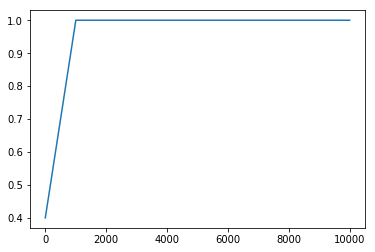

In [4]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)
plt.plot([beta_by_frame(i) for i in range(10000)])

## Setting for RL

In [5]:
action_dim = 1
state_dim = 1
hidden_dim = 200 

v_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_v_net = ValueNetwork(state_dim, hidden_dim).to(device)

for target_param, param in zip(target_v_net.parameters(), v_net.parameters()):
    target_param.data.copy_(param.data)

soft_q_1_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_2_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

v_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()


replay_buffer_size = 300000 # 1000000
# replay_buffer = ReplayBuffer(replay_buffer_size)
replay_buffer = NaivePrioritizedBuffer(replay_buffer_size)

# max_iteration  = 70000
# max_steps   = 500

# enviroment_step = 1

iteration   = 0
rewards     = []
losses = {"mean_loss": [],
         "std_loss": [],
         "z_loss": [],
         "v_loss": [],
         "q_1_loss": [],
         "q_2_loss": [],
         "policy_loss_with_reg": []}
batch_size  = 100

## Setting for Environment & Simulation

In [6]:
def U(C):
    utility = 1 / gamma * np.exp(-rho * t) * C**gamma
#    utility = 1 / gamma * (np.exp(gamma*C)-1)
    return utility * 1e+1


def f_B(t):
    ds = 0.01
    T_tilde = 110
    value = 0
    for s in np.arange(t, T_tilde, ds):
        w_s = np.exp(-rho*s/(1-gamma))
        tmp = (10**(beta + delta*s - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
        value += np.exp(- tmp + gamma/(1-gamma) * phi *(s-t)) * w_s * ds
    return value

def V_B(t, x):
    f_b = f_B(t)
    value_fcn = 1/gamma * f_b **(1-gamma) * x **gamma
    return value_fcn * 1e+1


alpha_ = [0.05, 0.07]
sigma_ = [0.2, 0.25]

theta = 0
beta = 4.59364
delta = 0.05032

r = 0.02
gamma = -3.#-3

rho = 0.04 # impatience factor

cov_matrix = np.array([[sigma_[0]*sigma_[0]*1, sigma_[0]*sigma_[1]*0.5],
                       [sigma_[1]*sigma_[0]*0.5, sigma_[1]*sigma_[1]*1]])
cov_inv = np.linalg.inv(cov_matrix)
theta_opt0 = (cov_inv[0][0]*(alpha_[0]-r) + cov_inv[0][1] * (alpha_[1]-r)) \
            / ((cov_inv[0][0]*(alpha_[0]-r) + (cov_inv[0][1] * (alpha_[1]-r))) + \
               (cov_inv[1][0] * (alpha_[0]-r) +(cov_inv[1][1]*(alpha_[1]-r)))) # 0.33333333333333326

theta_opt1 = 1 -theta_opt0 # 0.6666666666666667

alpha = theta_opt0*alpha_[0] + theta_opt1*alpha_[1]
sigma = np.sqrt(theta_opt0*theta_opt0*(sigma_[0]*sigma_[0]*1) + \
        theta_opt0*theta_opt1*(sigma_[0]*sigma_[1]*0.5) + \
        theta_opt1*theta_opt1*(sigma_[1]*sigma_[1]*1) + \
        theta_opt0*theta_opt1*(sigma_[0]*sigma_[1]*0.5))

X0 = 225.
g_B = 0
pi_opt = (alpha-r)/(sigma**2 *(1-gamma)) * (X0 + g_B)/X0




Asset = np.empty(21)
Asset_stack = []
C_stack = []

dt = 1

t0 = 70
y=70

def mu(t):
    value = (10**(beta + delta*(t+dt) - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
    return value

phi = r + (alpha -r)**2 / (2 * sigma**2 * (1-gamma))
rho = 0.04
#%%

## Original  Off-policy training

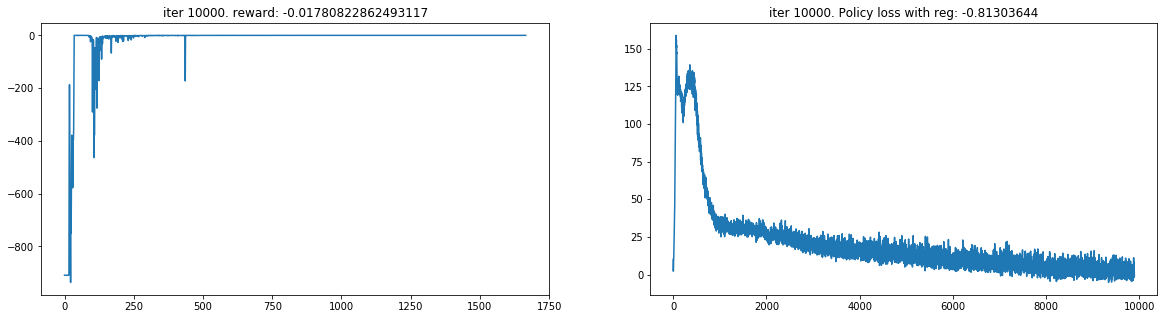

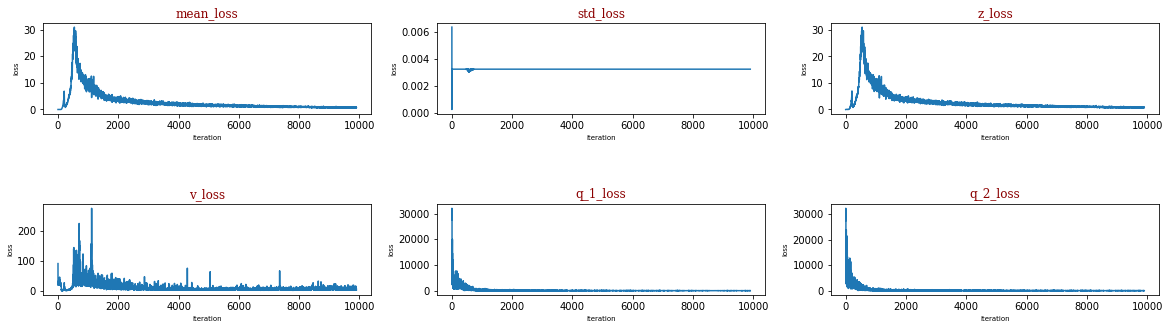

In [7]:
v_lr  = 3e-4
soft_q_lr = 6e-5
policy_lr = 3e-4
max_iteration = 10000

v_optimizer  = optim.Adam(v_net.parameters(), lr=v_lr)
soft_q_1_optimizer = optim.Adam(soft_q_1_net.parameters(), lr=3e-4)
soft_q_2_optimizer = optim.Adam(soft_q_2_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

soft_q1_scheduler = optim.lr_scheduler.CosineAnnealingLR(soft_q_1_optimizer, max_iteration, eta_min=0)




# Original training
while iteration < max_iteration:

    state = np.array(X0)
    episode_reward = 0
    
    for t in range(t0, t0+20):
        action = policy_net.get_action(state) # C_t
        Z = np.random.randn()
        # next_state, reward, done, _ = env.step(action)
        next_state = state*np.exp(((1-pi_opt)*r + pi_opt*alpha + mu(t)- action/state \
                                     -pi_opt**2 * sigma**2/2)*dt + pi_opt * sigma * np.sqrt(dt) * Z)
        
        tmp = (10**(beta + delta*t - 10)- 10**(beta + delta*t0 - 10))/(delta * np.log(10))
        
        if t != t0+5:
            reward = np.exp(-tmp)*U(C=action) # stage cost
#             reward = U(C=action)
            done = False
        else:
            state_before_rebal = state* (1+ (1-pi_opt)*r + pi_opt*alpha)
            reward = np.exp(-tmp) * V_B(t, state_before_rebal)# Terminal cost
#             reward = V_B(t, state_before_rebal)
            done = True
        
        
        replay_buffer.push(float(state), action, reward, float(next_state), done, t)
        
        if len(replay_buffer) > batch_size: 
            beta = beta_by_frame(iteration)
            loss_list = soft_q_update(batch_size, beta)
            soft_q1_scheduler.step()
            for i, (key, value) in enumerate(losses.items()):
                losses[key].append(loss_list[i])

        
        state = np.array(next_state)
        episode_reward += reward
        iteration += 1
        
        if iteration % 1000 == 0:
            plot(iteration, losses, rewards)
        
        if done:
            break
            
    
    rewards.append(episode_reward)

## Test

In [8]:
State_stack = []
Action_stack = []

dt = 1

def mu(t):
    value = (10**(beta + delta*(t+dt) - 10)- 10**(beta + delta*t - 10))/(delta * np.log(10))
    return value

for i in range(10000):
    state = np.array(X0)
    states = [state]
    actions = []
    for t in range(t0, t0+6):
        action = policy_net.get_action(state)
        Z = np.random.randn()
        
        next_state = state*np.exp(((1-pi_opt)*r + pi_opt*alpha + mu(t)- action/state \
                                     -pi_opt**2 * sigma**2/2)*dt + pi_opt * sigma * np.sqrt(dt) * Z)
        
        state = np.array(next_state)
        states.append(float(state))
        actions.append(action)
    State_stack.append(states)
    Action_stack.append(actions)
    
Asset_mean = np.mean(State_stack, axis=0)
C_mean = np.mean(Action_stack, axis=0)

[225.         197.87669071 173.7372782  152.10259296 132.89508079
 115.73019877 100.63145423]
[35.974842 32.02937  28.461912 25.326313 22.59754  19.938747]


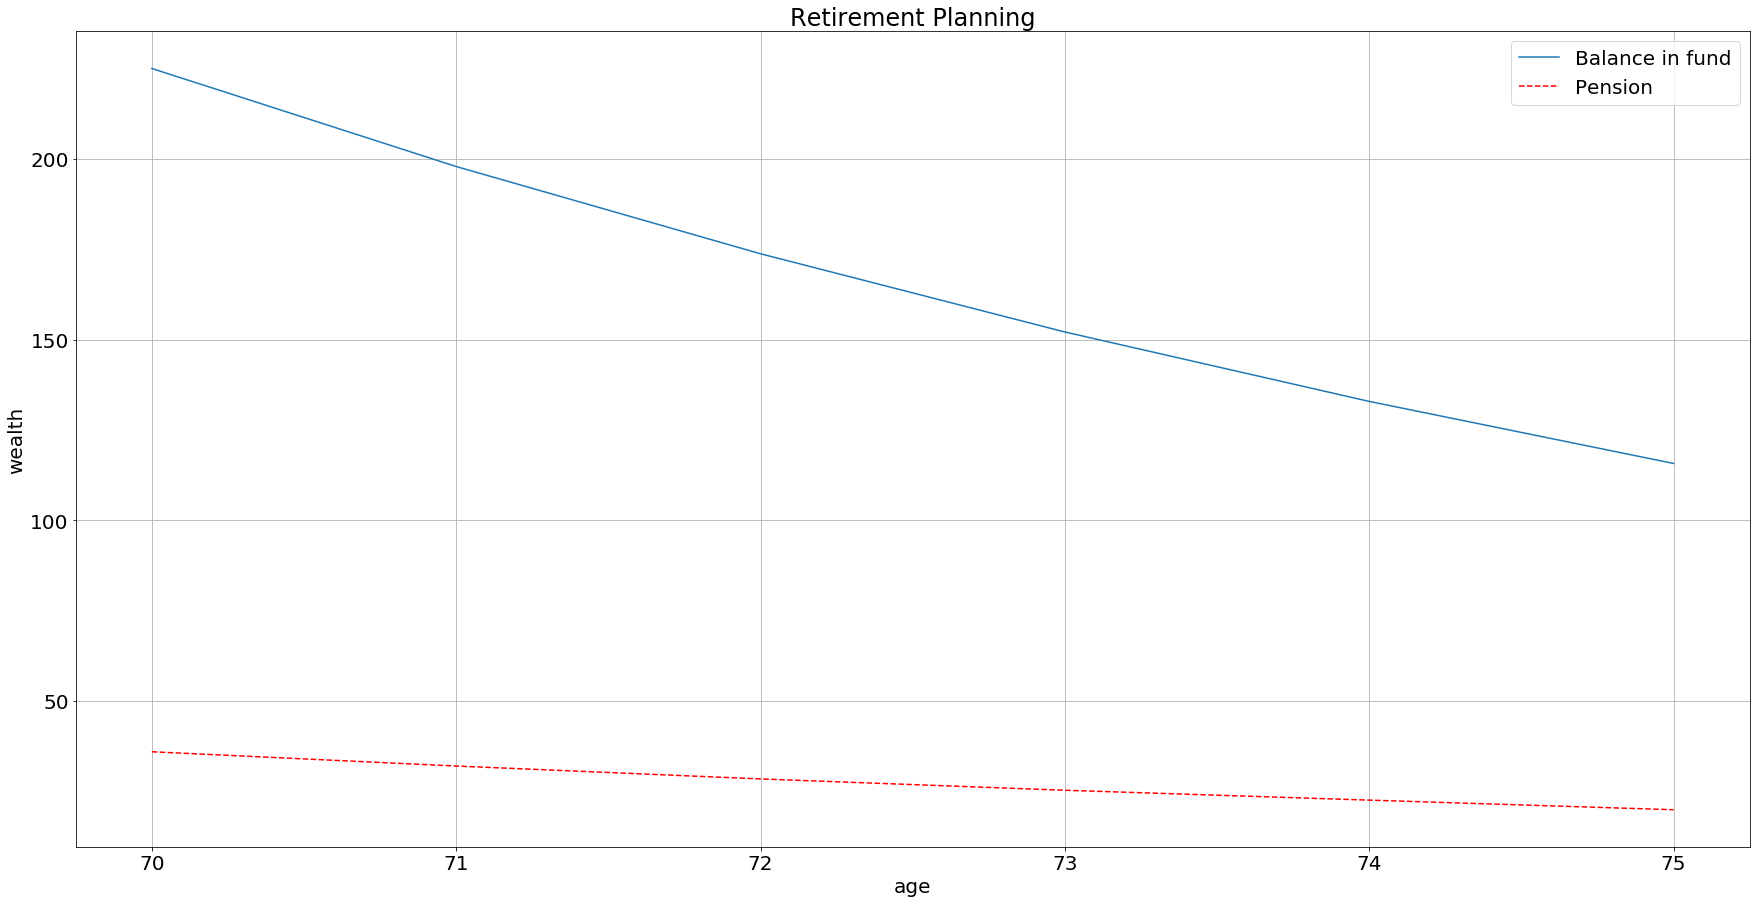

In [10]:
print(Asset_mean)
print(C_mean)

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})

plt.title('Retirement Planning')
plt.xlabel('age')
plt.ylabel('wealth')

plt.plot(range(70,76),Asset_mean[:-1], label='Balance in fund')
plt.plot(range(70,76),C_mean, '--', color = 'r', label='Pension')
plt.grid()
plt.legend()

well.. it needs to find better hyperparameters